In [2]:
import numpy as np
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix
import cv2
from matplotlib import pyplot as plt
import math

# code for different areas in pictire
MASK = 0                 
BOUNDRY = 1
OUTSIDE = 2

def in_mask(location, mask):
    '''
    A function to check if the input location is in the mask region.

    Args:
    location: ndarray (x,y) the location on a image
    mask: ndarray image that represents for mask. 1 for mask region and 0 for unmask region

    Returns
    A bool value 
    True if location in the mask region
    '''
    if mask[location] == 1:
        return True
    elif mask[location] == 0:
        return False
    else:
        return "Please first normalize mask!"

def get_nearby_locations(location):
    '''
    Get the four nearby locations around the input location

    Args:
    location: ndarray with two element

    Return:
    A list contains four tuples 
    '''
    x, y = location
    nearby = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
    return nearby


def in_boundry(location, mask):
    '''
    A function to detect if the location is on the boundry of mask
    Noted that we define "the boundry of mask" is in the mask
    '''
    if in_mask(location, mask) == False:
        return False
    else:
        for nearby_location in get_nearby_locations(location):
            if in_mask(nearby_location, mask) == False:
                return True
        
        return False
    

def point_location(location, mask):
    '''
    Detect what region s.t. the input location belong to 
    '''
    if in_mask(location,mask) == False:
        return OUTSIDE
    if in_boundry(location,mask) == True:
        return BOUNDRY
    return MASK


def Laplacian(source, location):
    '''
    Apply Laplacian operator to the location on the source image 
    '''
    x, y = location
    value = (4 * source[x,y])- (1 * source[x+1, y]) - (1 * source[x-1, y]) - (1 * source[x, y+1]) - (1 * source[x, y-1])
    return value


def mask_location(mask):
    '''
    Get all location that in the mask region
    '''
    x, y = np.nonzero(mask)
    return list(zip(x, y))


def get_templete_coordinate(mask, coef = 1.2):
    '''
    Function to get the template coordinate according to the mask 
    
    Para
    mask: A normalized mask image

    coef: To determain the size of templete         

    Return
    The four coordinaates 
    '''
    mask_height, mask_width = mask.shape

    x, y = np.nonzero(mask)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)

    x_mid = (x_max + x_min) / 2
    y_mid = (y_max + y_min) / 2

    # Get d = max - min
    # coef * d to determain the size of templete 
    w = x_max - x_min
    h = y_max - y_min
    w = coef * w
    h = coef * h

    x_min = np.max([x_mid - w/2, 0])
    x_max = np.min([x_mid + w/2, mask_width])
    y_min = np.max([y_mid - h/2, 0])
    y_max = np.min([y_mid + h/2, mask_height])

    return int(x_min), int(x_max), int(y_min), int(y_max)


# Create the A sparse matrix
def poisson_sparse_matrix(points):
    '''
    Create a sparse A matrix 
    '''
    # N = number of points in mask
    N = len(points)
    A = lil_matrix((N,N))
    
    for i,index in enumerate(points):
        A[i,i] = 4

        for x in get_nearby_locations(index):
            if x not in points: 
                continue
            j = points.index(x)
            A[i,j] = -1

    return A



def process(source, target, mask):
    locations = mask_location(mask)
    N = len(locations)
    # Create poisson A matrix. Contains mostly 0's, some 4's and -1's
    A = poisson_sparse_matrix(locations)

    # Create B matrix
    b = np.zeros(N)
    for i,location in enumerate(locations):
        # bi is the div of each point in mask
        b[i] = Laplacian(source, location)

        # if mask point is on the boundry 
        # add the constrain of target image
        if point_location(location, mask) == BOUNDRY:
            for pt in get_nearby_locations(location):
                if in_mask(pt,mask) == False:
                    b[i] += target[pt]

    x = linalg.cg(A, b)
    # Copy target photo, make sure as int
    composite = np.copy(target).astype(int)
    # Place new intensity on target at given index
    for i,location in enumerate(locations):
        composite[location] = x[0][i]
    return composite


def normalize_mask(mask_img):
    # Normalize mask to range [0,1]
    mask = mask_img.astype(np.float64) / 255.
    # Make mask binary
    mask[mask != 1] = 0
    mask[mask != 0] = 1

    # Trim to one channel
    mask = mask[:,:,0]

    return mask


def poission_blending(source_img, target_img, mask):
    num_channels = source_img.shape[-1]

    temp = []
    for i in range(num_channels):
        result = process(source_img[:,:,i], target_img[:,:,i], mask)
        temp.append(result)
        print(f"Finish channel {i}")
    # Merge the channels back into one image
    result = cv2.merge((temp[0], temp[1], temp[2]))

    # Write result
    return result



def template_matching(original_img, matching_img, mask, show_matching_part = False):
    '''
    Function to perform template matching

    Args:

    original_img: The RGB original image with mask 

    matching_img: The RGB matching image

    mask: 2_D Normal mask for orginal image. The unwanted region is labelled as 1

    show_matching_part: True will show the best matching patch (rectangle) in the matching image 
    
    Return

    best_matching: The area in the matching_img such that best matches the template

    template_in_original: template region in the original image

    template_mask: Because the orginal image has mask. we do not want the mask region
                   in the template affect the similar score 

    '''

    x_min, x_max, y_min, y_max = get_templete_coordinate(mask, coef=1.5)

    # read the matching image
    matching_img_gray = cv2.cvtColor(matching_img, cv2.COLOR_RGB2GRAY)

    # read the orginal image with mask 
    original_img_gray = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)

    # Get the template 
    template = original_img_gray[x_min:x_max, y_min:y_max]

    # Get the mask for template
    template_mask = (mask == 0).astype(np.uint8)
    template_mask = template_mask[x_min:x_max, y_min:y_max]

    # Do the template matching
    res = cv2.matchTemplate(matching_img_gray, template, cv2.TM_SQDIFF, mask = template_mask)

    (h, w) = template.shape

    # show the similarity
    print(np.min(res))

    # if want to see the matching patch in the matching image 
    # show the rectangle patch in the matching image 
    loc = np.where(res == np.min(res))
    for pt in zip(*loc[::-1]):
        if show_matching_part == True:
            cv2.rectangle(matching_img, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 2)
            plt.imshow(matching_img)

    best_matching = matching_img[pt[1]:pt[1] + h,pt[0]:pt[0] + w]
    template_in_original = original_img[x_min:x_max, y_min:y_max]

    return best_matching, template_in_original, template_mask

def three_dimention_mask(mask):
    (x,y) = mask.shape
    three_mask = np.zeros((x,y,3))
    for i in range(3):
        three_mask[:,:,i] = mask
    return three_mask

def enlarge_mask(mask):
    larger_mask = np.zeros_like(mask)
    x, y = np.nonzero(mask)
    x_min = math.floor(np.min(x)) - 1
    x_max = math.ceil(np.max(x)) + 2
    y_min = math.floor(np.min(y)) - 1 
    y_max = math.ceil(np.max(y)) + 2
    larger_mask[x_min:x_max, y_min:y_max] = 1
    # print(x_min, x_max, y_min, y_max)


    return larger_mask

def impaint(original_img, mask, blending_img):
    x_min, x_max, y_min, y_max = get_templete_coordinate(mask, coef=1.5)
    original_img[x_min:x_max, y_min:y_max] = blending_img
    return original_img

In [3]:
# First do template matching
mask = cv2.imread("scene completion image/2/forest_10000_mask.jpg")
mask = normalize_mask(mask)

matching_img = cv2.imread("scene completion image/2/matching.jpg")
matching_img = cv2.cvtColor(matching_img, cv2.COLOR_BGR2RGB)

original_img = cv2.imread("scene completion image/2/forest_10000.jpg")
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

best_matching, template_in_original, template_mask = template_matching(original_img, matching_img, mask)

64357828.0


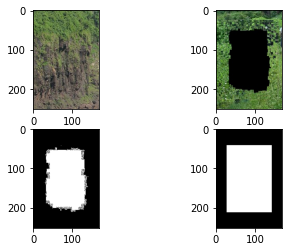

In [4]:
# 对上面的图片进行可视化
mask_ = template_mask == 0
plt.subplot(2,2,1)
plt.imshow(best_matching)
plt.subplot(2,2,2)
plt.imshow(template_in_original)
plt.subplot(2,2,3)
plt.imshow(mask_,"gray")


# 因为原图片在mask部位是黑色的，但是我们的mask
# 因为一些computational error不是正正好好每一个都和原图片上的mask对应
l_mask = enlarge_mask(mask_)
plt.subplot(2,2,4)
plt.imshow(l_mask,"gray")

Finish channel 0
Finish channel 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finish channel 2


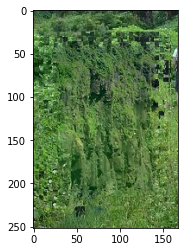

In [8]:
# 因为原图片在mask部位是黑色的，但是我们的mask
# 因为一些computational error不是正正好好每一个都和原图片上的mask对应
l_mask = enlarge_mask(mask_)
r = poission_blending(best_matching, template_in_original, l_mask)
plt.imshow(r)

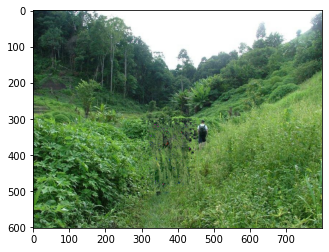

In [5]:
impaint_img = impaint(original_img, mask, r)
plt.imshow(impaint_img)